<a href="https://colab.research.google.com/github/adampotton/MDM3-Rep-3/blob/main/S2_MODELS/S2_CNN_model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import files, drive
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Mounted at /content/drive


#### Load csv of the amount of tree in each sample and choose classifciation mode

In [2]:
# 0 = species level (19 classes)
# 1 = genus level (14 classes)
# 2 = stand type (9 classes)
# 3 = foliage type (2 classes)
classification = 0

table = pd.read_csv('/content/drive/My Drive/S2 Data/labels.csv')
mapping = pd.read_csv('/content/drive/My Drive/S2 Data/tree_mapping.csv')
df = pd.DataFrame(mapping)

def extract_numbers(filename):
    return filename.split('_')[-3].replace('.tif', '')

table['File Number'] = table['File Name'].apply(extract_numbers)


#### Extract only the samples with pretty much just one sample and data split

In [25]:
numbers = np.load('/content/drive/My Drive/S2 Data All/numbers.npy')

tol = 0.99

table_numeric = table.apply(pd.to_numeric, errors='coerce')
columns_to_check = table_numeric.columns.difference(['File Number'])
filtered_table = table_numeric[(table_numeric[columns_to_check] >= tol).any(axis=1)]

indexes = np.where(np.isin(numbers, filtered_table['File Number']))[0]

arrays = np.load('/content/drive/My Drive/S2 Data All/arrays.npy')
labels = np.load('/content/drive/My Drive/S2 Data All/labels.npy')

arrays_reduced = arrays[indexes]
labels_reduced = labels[indexes]
numbers_reduced = numbers[indexes]

train_images, rest_images, train_names, rest_names, train_numbers, rest_numbers = train_test_split(
    arrays_reduced, labels_reduced, numbers_reduced, test_size=0.2, random_state=2, stratify=labels_reduced
)

test_images, val_images, test_names, val_names, test_numbers, val_numbers = train_test_split(
    rest_images, rest_names, rest_numbers, test_size=0.5, random_state=2, stratify=rest_names
)

#### Convert labels array to correct classes and a numbered labels array


In [4]:
def map_tree_name(name, classification):
    name = name.replace('_', ' ')
    row_number = df.index[df['Species'] == name][0]
    if classification == 0:
        return name
    elif classification == 1:
        return df.iloc[row_number, 1]
    elif classification == 2:
        return df.iloc[row_number, 2]
    elif classification == 3:
        return df.iloc[row_number, 3]

def apply_mapping(names, classification):
    return np.array([map_tree_name(name, classification) for name in names])

train_names2 = apply_mapping(train_names, classification)
test_names2 = apply_mapping(test_names, classification)
val_names2 = apply_mapping(val_names, classification)

tree_names, train_labels = np.unique(train_names2, return_inverse=True)
tree_names, test_labels = np.unique(test_names2, return_inverse=True)
tree_names, val_labels = np.unique(val_names2, return_inverse=True)

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)
val_images = val_images.astype(np.float32)


mean = np.mean(np.concatenate([train_images, test_images, val_images], axis=0), axis=(0, 1, 2))
std = np.std(np.concatenate([train_images, test_images, val_images], axis=0), axis=(0, 1, 2))

train_images = (train_images - mean) / std
test_images = (test_images - mean) / std
val_images = (val_images - mean) / std


#### Create Data Loaders


In [5]:
# Convert NumPy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

batch_size = 64

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#### Define the Model, and other parameters

In [6]:

num_channels = 12
num_classes = len(tree_names)
learning_rate = 0.001

model = nn.Sequential(
    nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),

    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 1 * 1, 256),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.00005)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=2)

#### Train, test, and validate, plotting validation loss

Validation accuracy after 2 epochs: 68.47%
Validation accuracy after 4 epochs: 68.63%
Validation accuracy after 6 epochs: 68.58%
Validation accuracy after 8 epochs: 68.41%
Validation accuracy after 10 epochs: 68.86%
Validation accuracy after 12 epochs: 68.86%
Validation accuracy after 14 epochs: 68.63%
Validation accuracy after 16 epochs: 68.52%
Validation accuracy after 18 epochs: 67.85%
Validation accuracy after 20 epochs: 68.07%
Test accuracy 68.07%


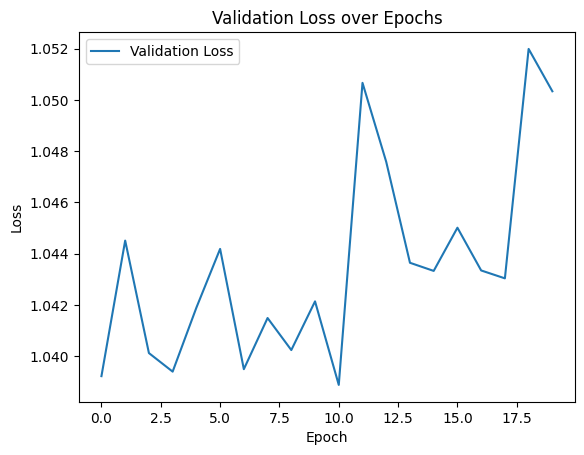

In [8]:
def train():
    model.train()
    all_logits = []
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images.permute(0, 3, 1, 2))

        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def validation(epoch):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images.permute(0, 3, 1, 2))

            loss = criterion(logits, labels)
            val_loss += loss.item()

            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

        val_loss /= len(test_loader)
        scheduler.step(val_loss)

        if (epoch + 1) % 2 == 0:
            print(f'Validation accuracy after {epoch+1} epochs: {accuracy:.2f}%')
    return val_loss

def test():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images.permute(0, 3, 1, 2))

            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
        print(f'Test accuracy {100 * correct / total:.2f}%')

num_epochs = 20
val_losses = []
for epoch in range(num_epochs):
    train()
    val_loss = validation(epoch)
    val_losses.append(val_loss)
test()

plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

#### Extract all logits form all images (after filtering)

In [51]:
all_arrays = arrays_reduced
all_labels = apply_mapping(labels_reduced, classification)
all_numbers = numbers_reduced

_, all_labels_numeric = np.unique(all_labels, return_inverse=True)
all_images = all_arrays.astype(np.float32)

mean = np.mean(all_images, axis=(0, 1, 2))
std = np.std(all_images, axis=(0, 1, 2))
all_images = (all_images - mean) / std

all_images_tensor = torch.tensor(all_images, dtype=torch.float32)
all_labels_tensor = torch.tensor(all_labels_numeric, dtype=torch.long)

all_dataset = TensorDataset(all_images_tensor, all_labels_tensor)
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False)


def logit_extract():
    model.eval()
    all_logits = []
    with torch.no_grad():

        for images, labels in all_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images.permute(0, 3, 1, 2))
            all_logits.append(logits)

        all_logits = torch.cat(all_logits, dim=0)

    return all_logits

all_logits = logit_extract()


In [98]:
i = 1888

print("\nPredicted class for index", i, ":",np.array(torch.argmax(all_logits[i], dim=0)))

print("\nTrue label for index", i, ":",all_labels_numeric[i],all_labels[i])

print("\nCorresponding number:", all_numbers[i])




Predicted class for index 1888 : 3

True label for index 1888 : 3 Betula spec.

Corresponding number: 19997
